# Time Series Forecasting with NeuralForecast 

In this tutorial, we will explain how to forecast time series data with Nixtla's [NeuralForecast](https://nixtlaverse.nixtla.io/neuralforecast/index.html). NeuralForecast is a Python library that offers a large collection of neural forecasting models, focusing on their performance, usability, and robustness.

We will use the [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy) dataset, which contains hierarchical sales data spanning five years from Walmart. The goal of this tutorial will be to forecast sales for the next 28 days as in the competition. 

First, we will generate several models from NeuralForecast and, using time series cross-validation on the training set, we will select the best model for each time series. Then, we will generate a 28-day-ahead forecast, mirroring the approach used in the competition. Finally, we will compare our forecast with the test set from the competition to evaluate overall performance.

**Outline:**
1. Load and visualize the data 
2. Perform time series cross-validation 
3. Select the best model for each series 
4. Run the forecast for the next 28 days
5. Evaluate the results 

## 1. Load and visualize data 

First, we'll load the M5 Competition dataset from a parquet file using `pandas`.

In [1]:
import pandas as pd 

Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')

In [2]:
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

Y_df = Y_df[Y_df['unique_id'].str.startswith("FOODS_3_001")].reset_index(drop=True) # use this line for a sample of the data

We'll use the `plot_series` function from [utilsforecast](https://nixtlaverse.nixtla.io/utilsforecast/index.html) to visualize the data. utilsforecast is another Python library from Nixtla designed to support various forecasting tasks. 

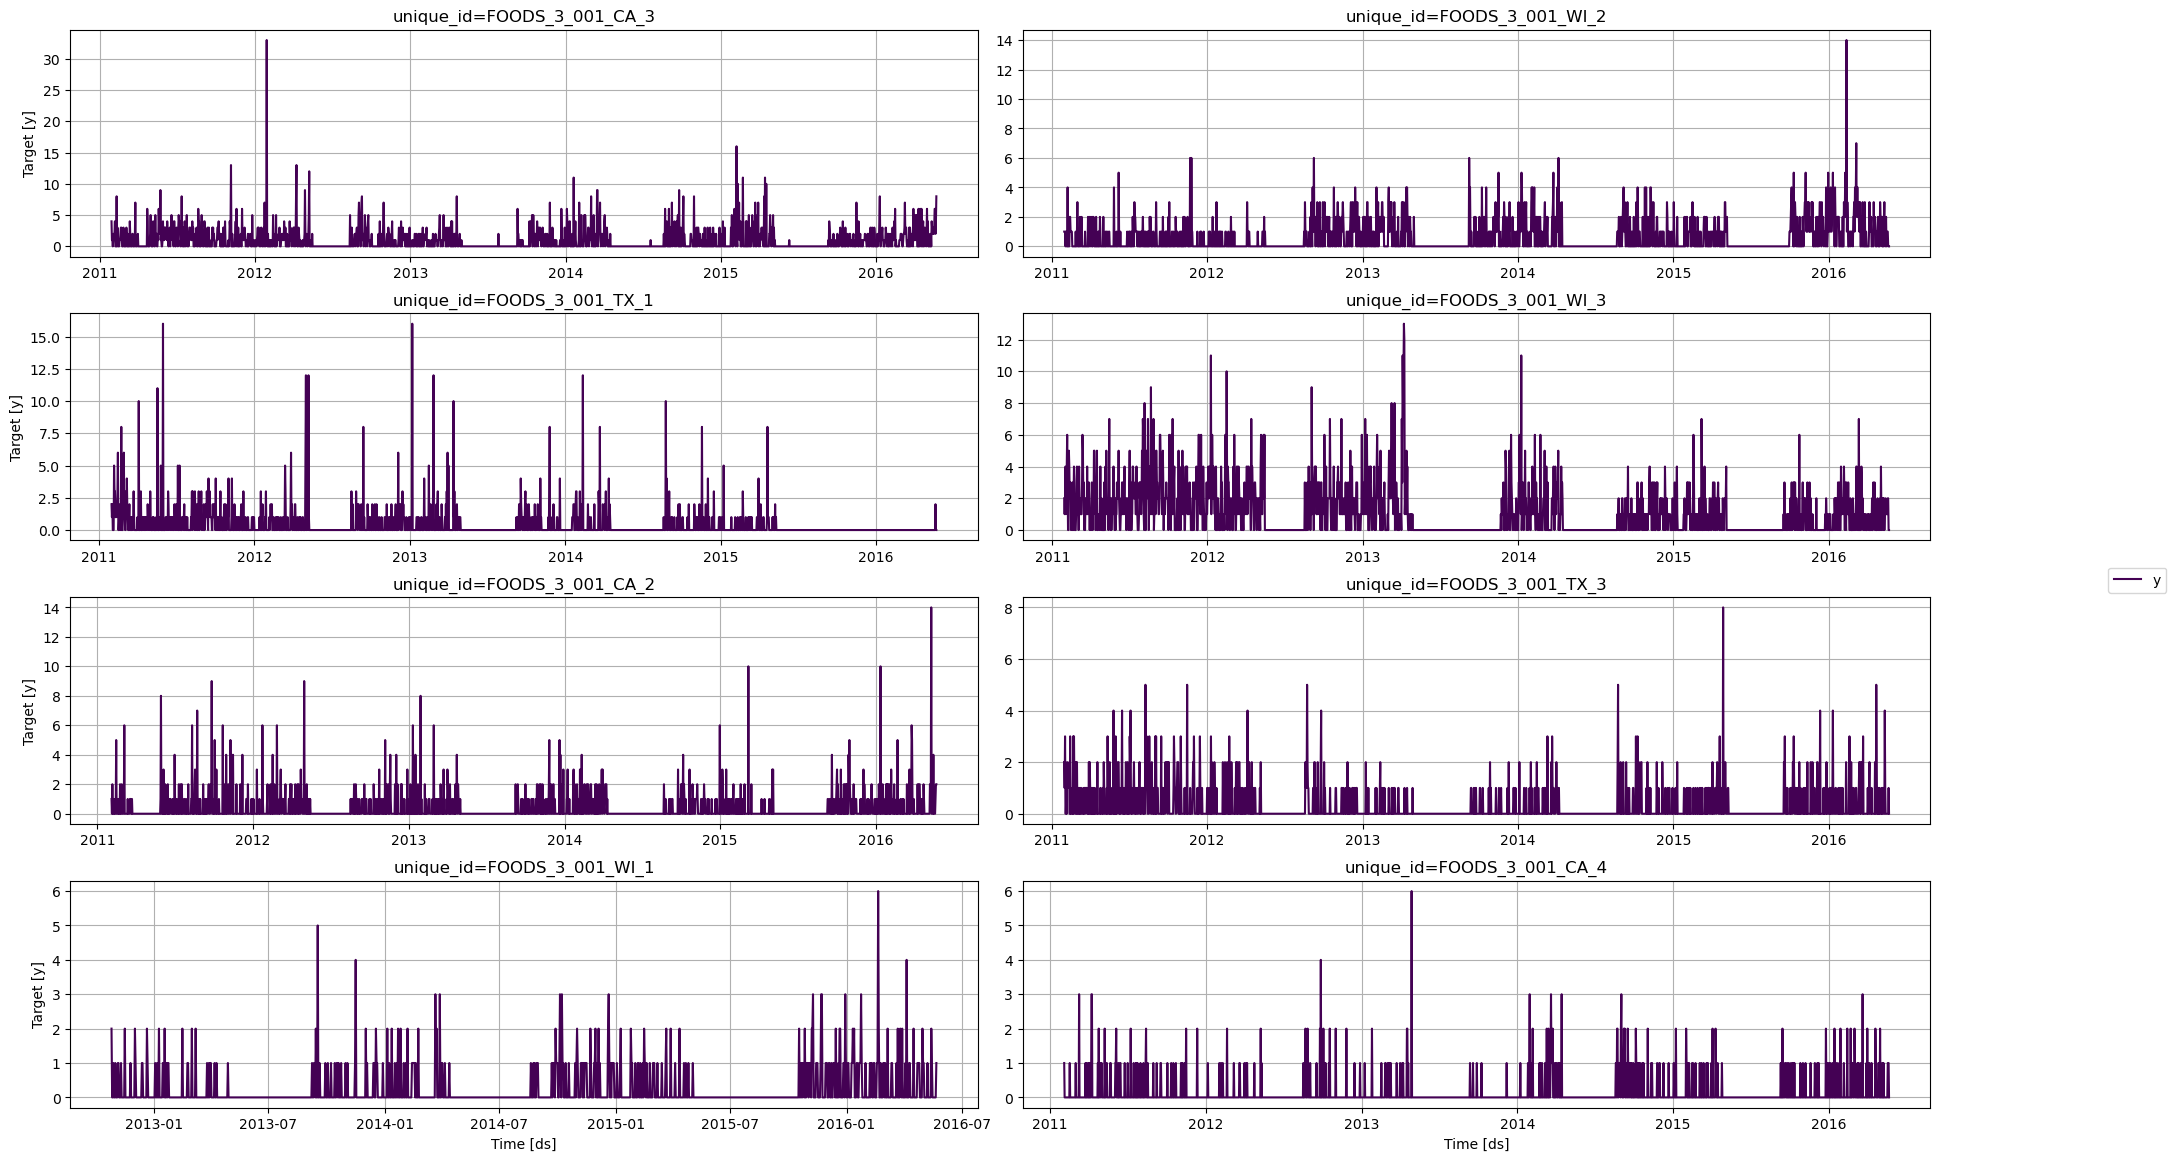

In [3]:
from utilsforecast.plotting import plot_series 

plot_series(Y_df)

## 2. Perform time series cross-validation

In [4]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoTFT, AutoDeepAR, AutoNBEATS
from neuralforecast.losses.pytorch import DistributionLoss

/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:265: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will ch

In [5]:
config_nhits = {
    "input_size": tune.choice([28, 28*2, 28*3, 28*5]),              
    "n_blocks": 5*[1],                                              
    "mlp_units": 5 * [[512, 512]],                                  
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   
    "scaler_type": tune.choice([None]),                             
    "max_steps": tune.choice([1000]),                               
    "batch_size": tune.choice([32, 64, 128, 256]),                  
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),       
    "random_seed": tune.randint(1, 20),                            
}

config_tft = {
        "input_size": tune.choice([28, 28*2, 28*3]),                
        "hidden_size": tune.choice([64, 128, 256]),                 
        "learning_rate": tune.loguniform(1e-4, 1e-2),               
        "scaler_type": tune.choice([None]),                        
        "max_steps": tune.choice([500, 1000]),                      
        "batch_size": tune.choice([32, 64, 128, 256]),              
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),  
        "random_seed": tune.randint(1, 20),                         
    }

config_deepar = {
    "input_size": tune.choice([28, 28*2, 28*3]),                 
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "scaler_type": tune.choice([None]),
    "max_steps": tune.choice([500, 1000]),
    "batch_size": tune.choice([32, 64, 128, 256]),
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),
    "random_seed": tune.randint(1, 20),
    }



In [6]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=28, config=config_nhits, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2),
        AutoTFT(h=28, config=config_tft, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2), 
        AutoDeepAR(h=28, config=config_deepar, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2)
    ],
    freq='D'
)

In [7]:
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=28)

(pid=66521) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=66521)   "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
(pid=66521) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=66521)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=66521) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:265: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=66521)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=66521) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFram

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 30.99it/s, v_num=0, train_loss_step=0.938, train_loss_epoch=0.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=66521) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 32.15it/s, v_num=0, train_loss_step=0.872, train_loss_epoch=0.878, valid_loss=0.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=66521) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 32.66it/s, v_num=0, train_loss_step=0.879, train_loss_epoch=0.864, valid_loss=0.191]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=66521) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 29.50it/s, v_num=0, train_loss_step=0.972, train_loss_epoch=0.932, valid_loss=0.194]
Validation: |          | 0/? [00:00<?, ?it

(_train_tune pid=66521) Seed set to 2


(_train_tune pid=66521) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.26it/s, v_num=0, train_loss_step=0.864, train_loss_epoch=0.894]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=66521) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s, v_num=0, train_loss_step=0.921, train_loss_epoch=0.852, valid_loss=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=66521) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 25.34it/s, v_num=0, train_loss_step=0.820, train_loss_epoch=0.835, valid_loss=0.203]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=66521) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 25.51it/s, v_num=0, train_loss_step=0.719, train_loss_epoch=0.822, valid_loss=0.206]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 

Seed set to 11


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s, v_num=0, train_loss_step=0.700, train_loss_epoch=0.672, valid_loss=0.203]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=66521) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=0, train_loss_step=0.700, train_loss_epoch=0.700, valid_loss=0.221]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

(_train_tune pid=66521) /Users/marianamenchero/miniforge3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=66521)   warnings.warn('resource_tracker: There appear to be %d '


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
cv_df = cv_df.reset_index()
cv_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoTFT,...,AutoTFT-lo-80,AutoTFT-hi-80,AutoTFT-hi-90,AutoDeepAR,AutoDeepAR-median,AutoDeepAR-lo-90,AutoDeepAR-lo-80,AutoDeepAR-hi-80,AutoDeepAR-hi-90,y
0,FOODS_3_001_CA_1,2016-02-29,2016-02-28,0.643,0.0,1.900002,0.000000,0.000000,0.099976,0.758,...,0.099998,0.900024,3.800049,0.75,1.0,0.0,0.0,2.0,2.049995,0.0
1,FOODS_3_001_CA_1,2016-03-01,2016-02-28,0.695,0.0,0.099998,0.099998,0.099976,0.000000,0.784,...,2.700005,3.700073,0.000000,0.74,1.0,0.0,0.0,2.0,3.000000,1.0
2,FOODS_3_001_CA_1,2016-03-02,2016-02-28,0.690,1.0,0.000000,0.000000,0.199951,0.000000,0.794,...,1.299995,0.900024,0.099976,0.69,0.0,0.0,0.0,2.0,3.000000,1.0
3,FOODS_3_001_CA_1,2016-03-03,2016-02-28,0.684,1.5,1.000000,1.800003,0.000000,0.000000,0.730,...,0.000000,1.800049,1.900024,0.61,0.0,0.0,0.0,2.0,2.000000,0.0
4,FOODS_3_001_CA_1,2016-03-04,2016-02-28,0.655,0.5,0.000000,1.800003,0.000000,1.950012,0.812,...,2.099998,0.099976,0.000000,0.64,0.0,0.0,0.0,2.0,2.000000,0.0


In [16]:
#cv_df.to_csv('cv_df.csv', index=False) # this is a temporary line to load results locally without running the cross-validation again
cv_df = pd.read_csv('cv_df.csv')

NeuralForecast generates a point forecast, a median forecast, and 80 and 90% prediction intervals. In this tutorial, we'll use the median forecast, which represents the 50th percentile of the predicted distribution. 

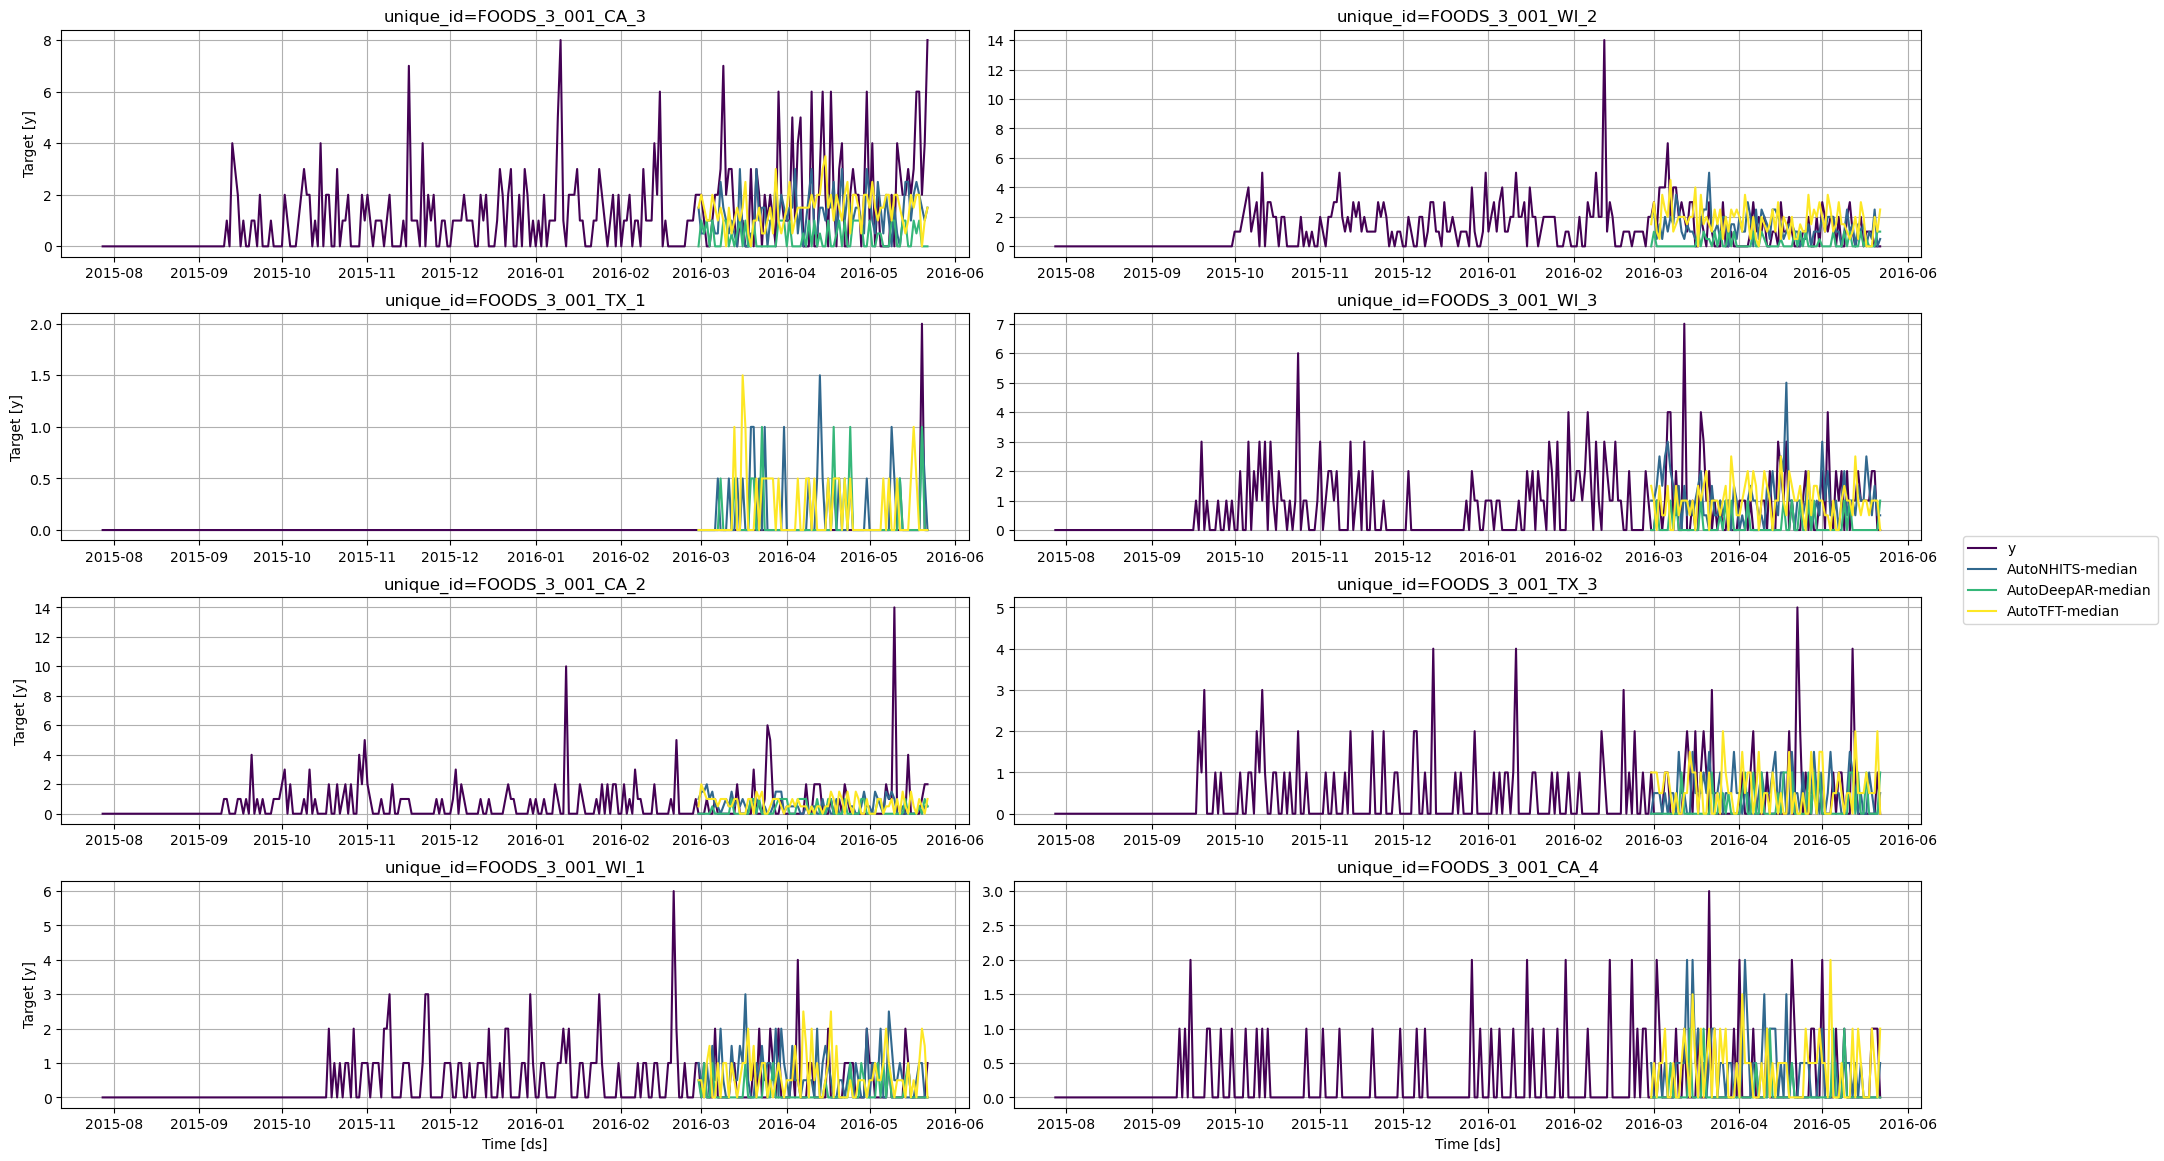

In [17]:
cv_df = cv_df[['unique_id', 'ds', 'cutoff', 'y', 'AutoNHITS-median', 'AutoDeepAR-median', 'AutoTFT-median']]

plot_series(Y_df, cv_df.drop(columns=['y', 'cutoff']), max_insample_length=300)

## 3. Select the best model for each series

In this section, we will evaluate the performance of each model for each time series and each cross-validation window.

In [18]:
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import mae 

In [19]:
models = ['AutoNHITS-median', 'AutoDeepAR-median', 'AutoTFT-median']
eval_cv = cv_df.groupby('cutoff').apply(lambda cv_df: evaluate(cv_df, metrics=[mae], models=models))

In [20]:
eval = eval_cv.groupby(['unique_id'])[models].mean().reset_index()
eval['best_model'] = eval[models].idxmin(axis=1)
eval.head()

,unique_id,AutoNHITS-median,AutoDeepAR-median,AutoTFT-median,best_model
0,FOODS_3_001_CA_1,0.654762,0.565476,0.708333,AutoDeepAR-median
1,FOODS_3_001_CA_2,0.976190,0.833333,1.059524,AutoDeepAR-median
2,FOODS_3_001_CA_3,1.529762,1.946429,1.684524,AutoNHITS-median
3,FOODS_3_001_CA_4,0.577381,0.351190,0.547619,AutoDeepAR-median
4,FOODS_3_001_TX_1,0.184524,0.083333,0.208333,AutoDeepAR-median


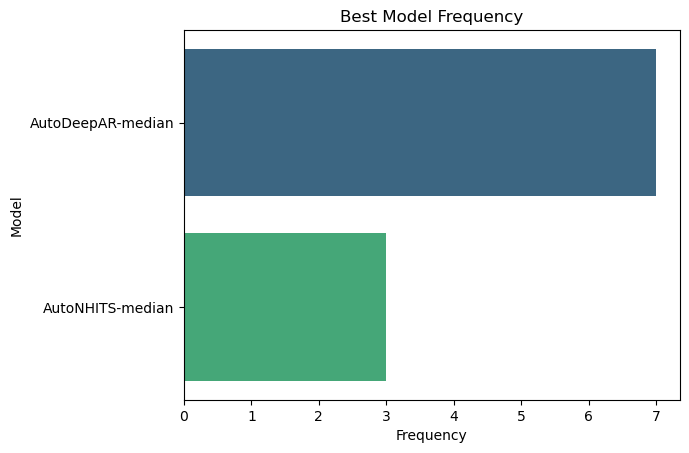

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

count_best_model = eval['best_model'].value_counts().reset_index()
count_best_model.columns = ['Model', 'Frequency']
 
sns.barplot(x='Frequency', y='Model', data=count_best_model, palette='viridis')
plt.title('Best Model Frequency')
plt.show()

In [28]:
best_model = {
    'AutoNHITS-median': eval[eval['best_model'] == 'AutoNHITS-median']['unique_id'].values,
    'AutoDeepAR-median': eval[eval['best_model'] == 'AutoDeepAR-median']['unique_id'].values,
    'AutoTFT-median': eval[eval['best_model'] == 'AutoTFT-median']['unique_id'].values
}

## 4. Run the forecast for the next 28 days

In [7]:
nf.fit(Y_df)

(pid=74379) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=74379)   "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
(pid=74379) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=74379)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=74379) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:265: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
(pid=74379)   pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
(pid=74379) /Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFram

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.91it/s, v_num=0, train_loss_step=0.941, train_loss_epoch=0.936]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=74379) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 24.79it/s, v_num=0, train_loss_step=0.949, train_loss_epoch=0.908, valid_loss=0.211]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=74379) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s, v_num=0, train_loss_step=0.912, train_loss_epoch=0.927, valid_loss=0.211]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=74379) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 27.62it/s, v_num=0, train_loss_step=0.929, train_loss_epoch=0.894, valid_loss=0.206]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [

(_train_tune pid=74379) Seed set to 8


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 32.07it/s, v_num=0, train_loss_step=0.860, train_loss_epoch=0.840]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=74379) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s, v_num=0, train_loss_step=0.967, train_loss_epoch=0.875, valid_loss=0.204]
(_train_tune pid=74379) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=74379) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 31.30it/s, v_num=0, train_loss_step=0.835, train_loss_epoch=0.946, valid_loss=0.215]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=74379) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 31.15it/s, v_num=0, train_loss_step=0.862, train_loss_epoch=0.865, valid_loss=0.213]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 

Seed set to 12


(_train_tune pid=74379) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, v_num=0, train_loss_step=0.958, train_loss_epoch=0.958, valid_loss=0.220]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

(_train_tune pid=74379) /Users/marianamenchero/miniforge3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=74379)   warnings.warn('resource_tracker: There appear to be %d '


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Next, we will use the `predict` method to forecast the next 28 days using the complete dataset. 

In [32]:
fcst_df = nf.predict()
fcst_df = fcst_df.reset_index()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [35]:
#fcst_df.to_csv('fcst_df.csv', index=False) # this is a temporary line to load results locally without running the predict method again
fcst_df = pd.read_csv('fcst_df.csv')

Now, for every `unique_id` we will select as the best model using the results from the time series cross-validation.

In [37]:
fcst_df = fcst_df[['unique_id', 'ds', 'AutoNHITS-median', 'AutoDeepAR-median', 'AutoTFT-median']]

In [49]:
models 

['AutoNHITS-median', 'AutoDeepAR-median', 'AutoTFT-median']

In [63]:
best_model_dfs = []  # A list to hold the best model for each unique_id

for model in models:
    model_df = fcst_df[fcst_df['unique_id'].isin(best_model[model])]
    model_df = model_df.rename(columns={model: 'best_model'})
    model_df = model_df.drop(columns=[col for col in best_model.keys() if col != model])
    best_model_dfs.append(model_df)

forecast = pd.concat(best_model_dfs, axis=0)


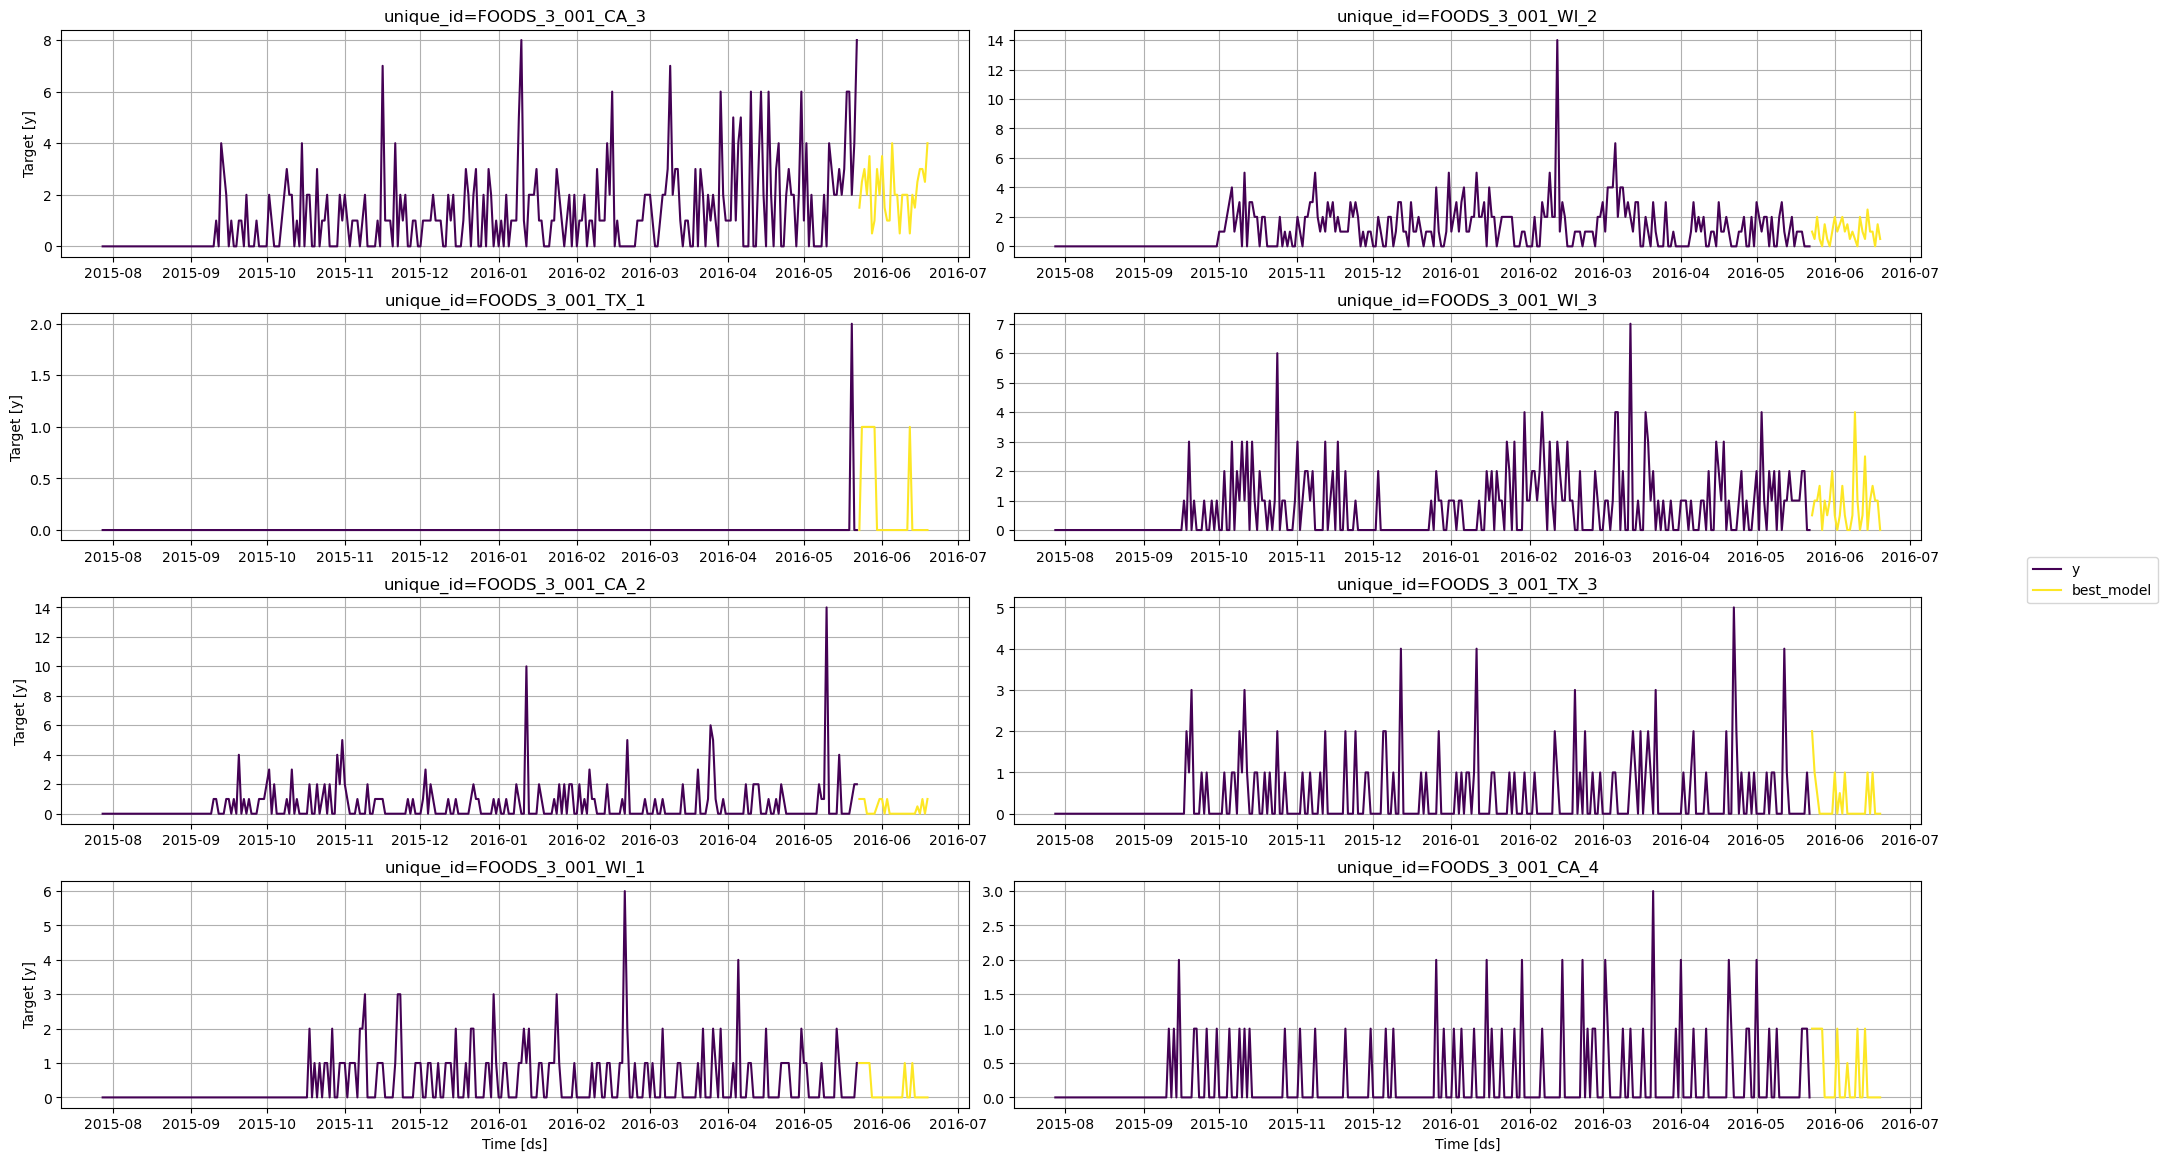

In [64]:
plot_series(Y_df, forecast, max_insample_length=300)

## 5. Evaluate the results 

In [55]:
test = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/test/target.parquet')